In [1]:
!pip -q install datasets transformers

In [2]:
import os

import sklearn
import sklearn.dummy
import datasets

from transformers import DistilBertTokenizer
from transformers import DistilBertModel

from nlphub import vizual

# extract last hidden state and use this data as features
from nlphub import hidden_state

%load_ext autoreload
%autoreload 2

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-5f8cab1121c1edc1.arrow
Loading cached processed dataset at /home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-7e9af1d6b1e26fb3.arrow
Loading cached processed dataset at /home/nikitakapitan/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-e344a69ef9b5a29d.arrow
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architectu

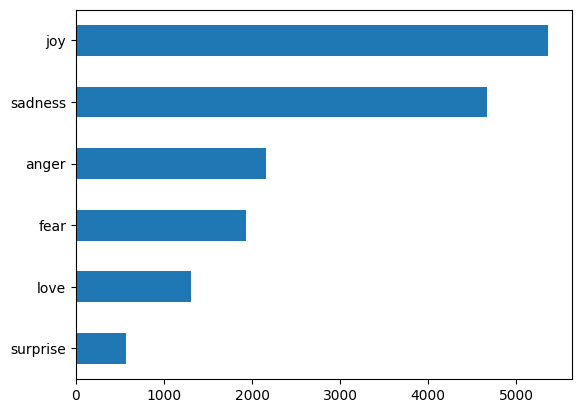

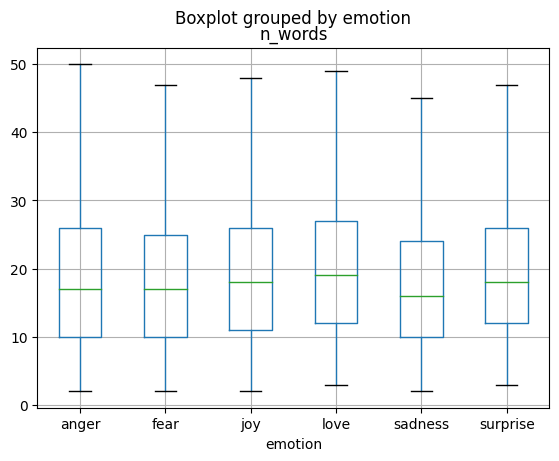

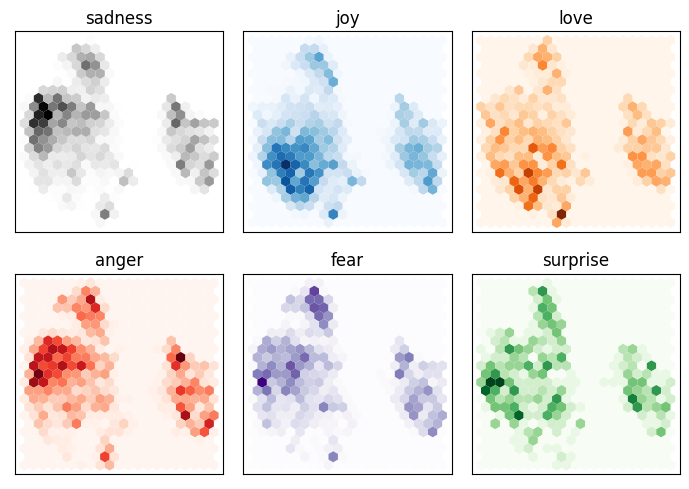

Dummy [Most Frequent] Classifier score: 0.352
LogReg trained on last hidden state score: 0.634


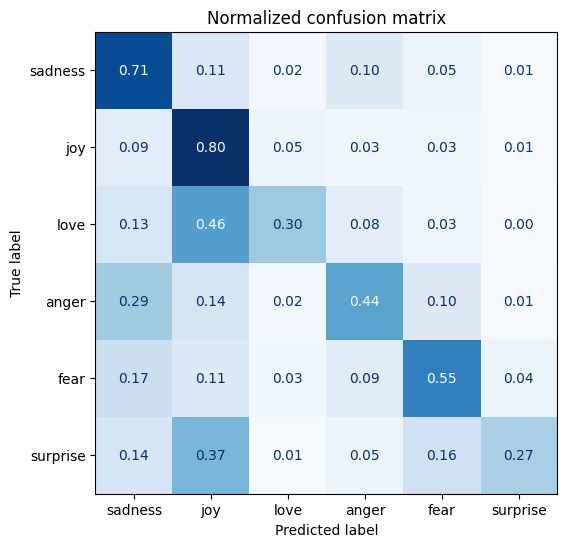

In [7]:
VIZUAL = True
HIDDEN_STATE_AS_FEATURES = True
CHECKPOINT = 'distilbert-base-uncased'

# DATA
emos = datasets.load_dataset('emotion')

VIZUAL and vizual.output_distribution(dataset=emos)

# TOKENIZER
tokenizer = DistilBertTokenizer.from_pretrained(CHECKPOINT)
tokenize = lambda batch : tokenizer(batch['text'], padding=True)

emos_encoded = emos.map(tokenize, batched=True, batch_size=None)

#MODEL
model = DistilBertModel.from_pretrained(CHECKPOINT)

# (Optional)
if HIDDEN_STATE_AS_FEATURES:
    
    emos_hidden = datasets.load_from_disk('emos_hidden') if os.path.exists('emos_hidden')\
        else hidden_state.get_hidden_state(data_encoded=emos_encoded, model=model, tokenizer=tokenizer)

    labels = emos_hidden["train"].features["label"].names
    X_train, X_valid, y_train, y_valid = hidden_state.prepare_data(data_hidden=emos_hidden)

    # UMAP2D projection
    VIZUAL and vizual.plot_umap(X_train=X_train, y_train=y_train, labels=labels)

    # Dummy [Most Frequent] Classification
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='most_frequent')
    dummy_clf.fit(X_train, y_train)

    print('Dummy [Most Frequent] Classifier score:', dummy_clf.score(X_valid, y_valid))

    # LogisticRegression Classification (~3 min)
    lr_clf = sklearn.linear_model.LogisticRegression(max_iter=3000)
    lr_clf.fit(X_train, y_train)
    
    print('LogReg trained on last hidden state score:', lr_clf.score(X_valid, y_valid))

    VIZUAL and vizual.plot_confusion_matrix(y_preds=lr_clf.predict(X_valid), y_true=y_valid, labels=labels)

    




